# Previsão de Churn usando Deep Learning
### Visão Geral

Este projeto tem como objetivo desenvolver um modelo de previsão de churn para uma empresa, utilizando técnicas de Deep Learning. O churn, ou a perda de clientes, é um problema significativo para muitas empresas e este projeto visa prever quais clientes estão mais propensos a deixar a empresa.

Como fonte de dados foi utilizado o dataset disponível no Kaggle [Marketing Insights for E-Commerce Company](https://www.kaggle.com/datasets/rishikumarrajvansh/marketing-insights-for-e-commerce-company?rvi=1).

In [2]:
# Import de bibliotecas necessárias ao desenvolvimento do projeto

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.metrics import categorical_crossentropy

import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Leitura dos arquivos de dados

A análise de churn deve ser feita na dimensão que contém as informações dos clientes. No conjunto de dados escolhido para realizar a análise, a tabela customers contém apenas 3 informações sobre os clientes: gênero, localização e tempo em meses de relacionamento do cliente com a empresa.

Como são poucas informações para se montar um modelo robusto de classificação, será carregada também a tabela Online_Sales que contém as informações de vendas da empresa no ano de 2019. A partir dessa tabela serão realizados processamento e feature engineering para levantar informações sobre o comportamento de cada cliente e enriquecer a tabela cutomers.

In [5]:
customers = pd.read_excel('/content/drive/My Drive/Projetos Machine Learning/Churn/CustomersData.xlsx')
sales = pd.read_csv('/content/drive/My Drive/Projetos Machine Learning/Churn/Online_Sales.csv')

# Pré-Análise de Dados

## Introdução
Nesta etapa, foi feita uma exploração dos dados para uma análise mais aprofundada. Isso inclui uma visão geral dos conjuntos de dados e operações básicas de verificação.

## Visão Geral dos Dados
Os conjuntos de dados incluem informações sobre clientes e vendas, fornecidos nos arquivos 'customers.csv' e 'online_sales.csv'.

## Informações Gerais
- **Dados dos Clientes:** Os dados dos clientes contêm informações sobre gênero, localização e tempo de relacionamento.
- **Dados de Vendas:** Os dados de vendas incluem informações detalhadas sobre as transações, como data, produto, preço, entre outros. Vale observar que as informações na tabela de vendas estão no nível de item, ou seja, cada registro é um determinado item em uma venda.

## Estatísticas Descritivas
As estatísticas descritivas fornecem uma visão resumida dos dados, destacando medidas como média, desvio padrão, mínimo, máximo e quartis.

## Valores Nulos
É essencial verificar a presença de valores nulos nos dados para lidar com possíveis lacunas ou inconsistências.

### Valores Nulos
- **Clientes:** Não foram identificados valores nulos nos dados de clientes.
- **Vendas:** Os dados de vendas não apresentaram valores nulos significativos.

Essas operações iniciais são fundamentais para entender a natureza dos dados e preparar o terreno para análises mais detalhadas.


In [6]:
# Visualizar as primeiras linhas dos DataFrames
print("---- Primeiras linhas dos dados de clientes ----")
print(customers.head())

print("\n---- Primeiras linhas dos dados de vendas ----")
print(sales.head())

# Informações gerais dos DataFrames
print("\n---- Informações dos dados de clientes ----")
print(customers.info())

print("\n---- Informações dos dados de vendas ----")
print(sales.info())

# Estatísticas descritivas
print("\n---- Estatísticas descritivas dos dados de clientes ----")
print(customers.describe())

print("\n---- Estatísticas descritivas dos dados de vendas ----")
print(sales.describe())

# Verificar valores nulos
print("\n---- Valores nulos nos dados de clientes ----")
print(customers.isnull().sum())

print("\n---- Valores nulos nos dados de vendas ----")
print(sales.isnull().sum())

---- Primeiras linhas dos dados de clientes ----
   CustomerID Gender    Location  Tenure_Months
0       17850      M     Chicago             12
1       13047      M  California             43
2       12583      M     Chicago             33
3       13748      F  California             30
4       15100      M  California             49

---- Primeiras linhas dos dados de vendas ----
   CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0       17850           16679         1/1/2019  GGOENEBJ079499   
1       17850           16680         1/1/2019  GGOENEBJ079499   
2       17850           16681         1/1/2019  GGOEGFKQ020399   
3       17850           16682         1/1/2019  GGOEGAAB010516   
4       17850           16682         1/1/2019  GGOEGBJL013999   

                                 Product_Description Product_Category  \
0  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   

## Transformação da Data de Transação

A coluna 'Transaction_Date' nos dados de vendas passou por uma etapa de processamento na qual os valores originais foram convertidos para o formato de datetime.

Essa transformação é fundamental para permitir análises temporais mais detalhadas.

In [7]:
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  int64         
 1   Transaction_ID       52924 non-null  int64         
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 4.0+ MB


# Pré-processamento dos Dados de Vendas

Nesta seção, várias etapas são realizadas para enriquecer e extrair informações relevantes sobre o comportamento de compra de cada cliente a partir dos dados de vendas.

## Cálculo das Datas de Compra
- Utilizando a data de transação, são determinadas a última e a primeira compra de cada cliente.
- `last_sale_date` e `first_sale_date` registram a data da última e primeira compra de cada cliente, respectivamente.

## Intervalo de Compras
- A fusão dos DataFrames `last_sale_date` e `first_sale_date` resulta no cálculo do intervalo em dias entre a primeira e última compra de cada cliente.
- O DataFrame `sale_date_info` é gerado, contendo o intervalo em dias (`days_between_sales`).

## Informações de Compra por Cliente
- `count_sales` calcula a quantidade de pedidos únicos por cliente.
- `used_coupon_count` conta o número de cupons de desconto utilizados por cliente.
- `unique_items_count` determina a contagem de itens únicos comprados por cliente.
- `items_count` registra a quantidade total de itens adquiridos por cada cliente.
- `total_delivery_charges` calcula o montante total gasto em cobrança de frete por cliente.

## Total Gasto por Cliente na Tabela de Vendas
- O DataFrame é enriquecido com a coluna 'Total_Spent', que representa o valor total gasto pelo cliente em cada transação na tabela de vendas, considerando o preço médio e a quantidade de itens adquiridos.
- `total_spent_by_customer` calcula o total gasto em compras por cliente.

Essas operações são essenciais para preparar os dados, enriquecendo-os com informações significativas sobre o comportamento de compra de cada cliente, auxiliando na busca por padrões que permitam a implementação de um bom modelo de classificação.


In [8]:
# Calcular data da útima compra de cada cliente
last_sale_date = sales.groupby('CustomerID')['Transaction_Date'].max().reset_index()
last_sale_date.rename(columns={'Transaction_Date': 'last_sale_date'}, inplace=True)
print(last_sale_date)

# Calcular a data da primeira compra de cada cliente
first_sale_date = sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_sale_date.rename(columns={'Transaction_Date': 'first_sale_date'}, inplace=True)
print(first_sale_date)

# Unir os dataframes
sale_date_info = first_sale_date.merge(last_sale_date, on='CustomerID', how='left')

# Calcular intervalo em dias entre a primeira e última compra de cada cliente
sale_date_info['days_between_sales'] = sale_date_info['last_sale_date'] - sale_date_info['first_sale_date']
sale_date_info['days_between_sales'] = sale_date_info['days_between_sales'].dt.days.astype(int)
print(sale_date_info)

# Calcular quantidade de pedidos por cliente
count_sales = sales.groupby('CustomerID')['Transaction_ID'].nunique().reset_index()
count_sales.rename(columns={'Transaction_ID': 'count_sales'}, inplace=True)
print(count_sales)

# Calcular quantidade de cupons de desconto utilizados por cliente
used_coupon_count = sales[sales['Coupon_Status'] == 'Used'].groupby('CustomerID')['Coupon_Status'].count().reset_index()
used_coupon_count.rename(columns={'Coupon_Status': 'used_coupon_count'}, inplace=True)
print(used_coupon_count)

# Calcular quantidade de itens únicos por cliente
unique_items_count = sales.groupby('CustomerID')['Product_SKU'].nunique().reset_index()
unique_items_count.rename(columns={'Product_SKU': 'unique_items_count'}, inplace=True)
print(unique_items_count)

# Calcular a quantidade total de itens por cliente
items_count = sales.groupby('CustomerID')['Quantity'].sum().reset_index()
items_count.rename(columns={'Quantity': 'items_count'}, inplace=True)
print(items_count)

# Calcular o total de cobrança de frete por cliente
total_delivery_charges = sales.groupby('CustomerID')['Delivery_Charges'].sum().reset_index()
total_delivery_charges.rename(columns={'Delivery_Charges': 'total_delivery_charges'}, inplace=True)
print(total_delivery_charges)

# Calcular o valor total gasto por cliente na tabela "sales"
sales['Total_Spent'] = sales['Avg_Price'] * sales['Quantity']
total_spent_by_customer = sales.groupby('CustomerID')['Total_Spent'].sum().reset_index()
total_spent_by_customer.rename(columns={'Total_Spent': 'total_spent'}, inplace=True)
print(total_spent_by_customer)



      CustomerID last_sale_date
0          12346     2019-09-15
1          12347     2019-11-02
2          12348     2019-10-19
3          12350     2019-12-14
4          12356     2019-09-15
...          ...            ...
1463       18259     2019-04-05
1464       18260     2019-10-05
1465       18269     2019-06-20
1466       18277     2019-10-23
1467       18283     2019-10-10

[1468 rows x 2 columns]
      CustomerID first_sale_date
0          12346      2019-09-15
1          12347      2019-03-24
2          12348      2019-06-22
3          12350      2019-12-14
4          12356      2019-09-15
...          ...             ...
1463       18259      2019-04-05
1464       18260      2019-06-22
1465       18269      2019-04-05
1466       18277      2019-10-23
1467       18283      2019-07-29

[1468 rows x 2 columns]
      CustomerID first_sale_date last_sale_date  days_between_sales
0          12346      2019-09-15     2019-09-15                   0
1          12347      2019-03-24  

# Fusão dos dados obtidos anteriormente à tabela de clientes

In [9]:
customers = pd.read_excel('/content/drive/My Drive/Projetos Machine Learning/Churn/CustomersData.xlsx')

customers = customers.merge(sale_date_info, on='CustomerID', how='left')
customers = customers.merge(count_sales, on='CustomerID', how='left')
customers = customers.merge(used_coupon_count, on='CustomerID', how='left')
customers['used_coupon_count'].fillna(0, inplace=True)
customers = customers.merge(unique_items_count, on='CustomerID', how='left')
customers = customers.merge(items_count, on='CustomerID', how='left')
customers = customers.merge(total_delivery_charges, on='CustomerID', how='left')
customers = customers.merge(total_spent_by_customer, on='CustomerID', how='left')
customers.head()

,CustomerID,Gender,Location,Tenure_Months,first_sale_date,last_sale_date,days_between_sales,count_sales,used_coupon_count,unique_items_count,items_count,total_delivery_charges,total_spent
0,17850,M,Chicago,12,2019-01-01,2019-01-26,25,177,91.0,119,1133,3162.62,34551.40
1,13047,M,California,43,2019-01-01,2019-12-18,351,26,18.0,33,175,315.96,3048.79
2,12583,M,Chicago,33,2019-01-01,2019-08-02,213,15,12.0,40,155,757.27,2361.48
3,13748,F,California,30,2019-01-01,2019-01-01,0,1,0.0,1,1,6.50,1.24
4,15100,M,California,49,2019-01-01,2019-08-30,241,6,2.0,5,15,64.38,1043.72


# Criação de Novas Colunas em 'customers'

Após o processamento e enriquecimento dos dados, foram adicionadas novas colunas ao DataFrame 'customers'. Essas novas features buscam agregar informações adicionais sobre o comportamento de compra de cada cliente:

### Novas Colunas:
1. **'order_frequency':**
   - Calcula a frequência média de pedidos por dia para cada cliente, levando em consideração o número total de dias entre a primeira e última compra, bem como o número de pedidos.

2. **'use_coupon_rate':**
   - Registra a taxa média de utilização de cupons de desconto por pedido para cada cliente.

3. **'avg_items_by_order':**
   - Indica a quantidade média de itens por pedido para cada cliente.

4. **'avg_delivery_charges_by_order':**
   - Calcula o valor médio gasto com cobrança de frete por pedido para cada cliente.

5. **'avg_spent_by_order':**
   - Registra o gasto médio por pedido para cada cliente, considerando o valor total gasto e o número de pedidos realizados.

Essas novas colunas oferecem insights valiosos sobre o padrão de compra de cada cliente, incluindo frequência, comportamento de gastos, e uso de cupons de desconto, enriquecendo o DataFrame 'customers' para análises posteriores e a construção de modelos de previsão de churn.


In [10]:
# Gerando mais colunas com informações

customers['order_frequency'] = np.where(customers['days_between_sales'] != 0,
                                 customers['count_sales'] / customers['days_between_sales'],
                                 0)

customers['use_coupon_rate'] = np.where(customers['count_sales'] != 0,
                                 customers['used_coupon_count'] / customers['count_sales'],
                                 0)

customers['avg_items_by_order'] = np.where(customers['count_sales'] != 0,
                                 customers['items_count'] / customers['count_sales'],
                                 0)

customers['avg_delivery_charges_by_order'] = np.where(customers['count_sales'] != 0,
                                 customers['total_delivery_charges'] / customers['count_sales'],
                                 0)

customers['avg_spent_by_order'] = np.where(customers['count_sales'] != 0,
                                 customers['total_spent'] / customers['count_sales'],
                                 0)

customers.head()

,CustomerID,Gender,Location,Tenure_Months,first_sale_date,last_sale_date,days_between_sales,count_sales,used_coupon_count,unique_items_count,items_count,total_delivery_charges,total_spent,order_frequency,use_coupon_rate,avg_items_by_order,avg_delivery_charges_by_order,avg_spent_by_order
0,17850,M,Chicago,12,2019-01-01,2019-01-26,25,177,91.0,119,1133,3162.62,34551.40,7.080000,0.514124,6.401130,17.867910,195.205650
1,13047,M,California,43,2019-01-01,2019-12-18,351,26,18.0,33,175,315.96,3048.79,0.074074,0.692308,6.730769,12.152308,117.261154
2,12583,M,Chicago,33,2019-01-01,2019-08-02,213,15,12.0,40,155,757.27,2361.48,0.070423,0.800000,10.333333,50.484667,157.432000
3,13748,F,California,30,2019-01-01,2019-01-01,0,1,0.0,1,1,6.50,1.24,0.000000,0.000000,1.000000,6.500000,1.240000
4,15100,M,California,49,2019-01-01,2019-08-30,241,6,2.0,5,15,64.38,1043.72,0.024896,0.333333,2.500000,10.730000,173.953333


# Definição do Label de Churn

Para os propósitos deste projeto específico, uma regra de negócio foi estabelecida para determinar o rótulo de churn ('Churn' ou 'Não Churn') para cada cliente no conjunto de dados. É importante observar que a definição de churn pode variar de acordo com as estratégias e necessidades específicas de cada empresa.

## Relevância da Definição de Churn:
- A regra adotada para determinar o churn considera a última compra realizada por cada cliente em relação a uma data de referência (01 de janeiro de 2020). Isso foi estabelecido exclusivamente para este projeto, visando a construção de um modelo de previsão de churn para análises.

### Considerações Importantes:
- A definição de churn pode variar significativamente entre diferentes empresas e setores, sendo estabelecida com base em métricas de engajamento, comportamento do cliente, entre outros fatores específicos do contexto empresarial.

### Processo de Criação do Label:
- Utilizando a data de referência 'target_date' e a coluna 'last_sale_date' no DataFrame 'customers', foi aplicada uma condição para determinar se a diferença de dias entre a data de referência e a última compra é superior a 180 dias.
- O rótulo 'churn' é definido como 'yes' para clientes que atendem a essa condição e 'no' para os demais.

Essa etapa é crucial na preparação dos dados para a modelagem de previsão de churn, permitindo identificar os clientes que podem ser considerados em risco de deixar de fazer negócios com a empresa.



In [11]:
# Criar o label - Churn sim ou não
# Regra de negócio: última compra há mais de 180 dias é considero Churn

# Definir a data de referência
target_date = pd.to_datetime('2020-01-01')

customers['churn'] = np.where((target_date - customers['last_sale_date']).dt.days > 180, 'yes', 'no')
customers.head()

,CustomerID,Gender,Location,Tenure_Months,first_sale_date,last_sale_date,days_between_sales,count_sales,used_coupon_count,unique_items_count,items_count,total_delivery_charges,total_spent,order_frequency,use_coupon_rate,avg_items_by_order,avg_delivery_charges_by_order,avg_spent_by_order,churn
0,17850,M,Chicago,12,2019-01-01,2019-01-26,25,177,91.0,119,1133,3162.62,34551.40,7.080000,0.514124,6.401130,17.867910,195.205650,yes
1,13047,M,California,43,2019-01-01,2019-12-18,351,26,18.0,33,175,315.96,3048.79,0.074074,0.692308,6.730769,12.152308,117.261154,no
2,12583,M,Chicago,33,2019-01-01,2019-08-02,213,15,12.0,40,155,757.27,2361.48,0.070423,0.800000,10.333333,50.484667,157.432000,no
3,13748,F,California,30,2019-01-01,2019-01-01,0,1,0.0,1,1,6.50,1.24,0.000000,0.000000,1.000000,6.500000,1.240000,yes
4,15100,M,California,49,2019-01-01,2019-08-30,241,6,2.0,5,15,64.38,1043.72,0.024896,0.333333,2.500000,10.730000,173.953333,no


In [14]:
# Realizar análises de Churn

percentage_churn = customers['churn'].value_counts(normalize=True) * 100
print(percentage_churn)

# Armazena proporções para cálculo do bias no modelo de classificação
pos = percentage_churn[1]
neg = percentage_churn[0]


no     65.735695
yes    34.264305
Name: churn, dtype: float64


In [26]:
def plot_churn(ch_no, ch_yes, label):
  # Contagem de 'no' e 'yes' para cada gênero
  no_counts = ch_no.value_counts()
  yes_counts = ch_yes.value_counts()

  # Calculando as porcentagens de 'no' e 'yes' em relação ao total
  total_counts = customers[label].value_counts()
  no_percent = (no_counts / total_counts) * 100
  yes_percent = (yes_counts / total_counts) * 100

  # Plotagem do gráfico de barras empilhadas
  plt.bar(no_counts.index, no_counts, label='No')
  plt.bar(yes_counts.index, yes_counts, bottom=no_counts, label='Yes')

  # Adicionando rótulos e legenda
  plt.xlabel(label)
  plt.ylabel('Counts')
  plt.legend()

  # Adicionando rótulos para 'no' e 'yes' em cada barra
  for i, value in enumerate(no_counts):
      plt.text(i, value / 2, f"{value} ({no_percent[i]:.2f}%)", ha='center', color='white')
      plt.text(i, value + (yes_counts[i] / 2), f"{yes_counts[i]} ({yes_percent[i]:.2f}%)", ha='center', color='white')

  plt.show()

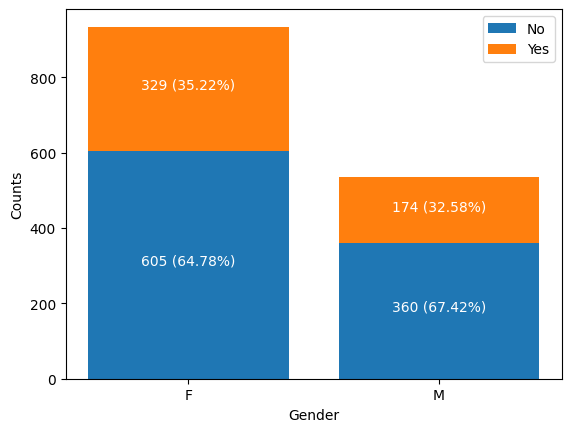

In [27]:
# Proporção de churn por Gender
ch_no = customers[customers.churn == 'no'].Gender
ch_yes = customers[customers.churn == 'yes'].Gender

plot_churn(ch_no, ch_yes, 'Gender')

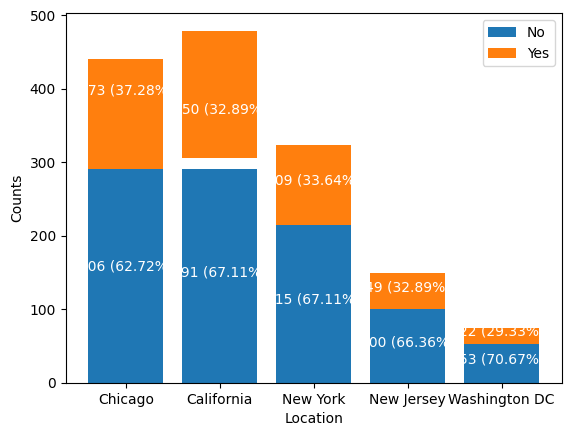

In [33]:
# Proporção de churn por Location
ch_no = customers[customers.churn == 'no'].Location
ch_yes = customers[customers.churn == 'yes'].Location

plot_churn(ch_no, ch_yes, 'Location')

Churn por Tenure_Months


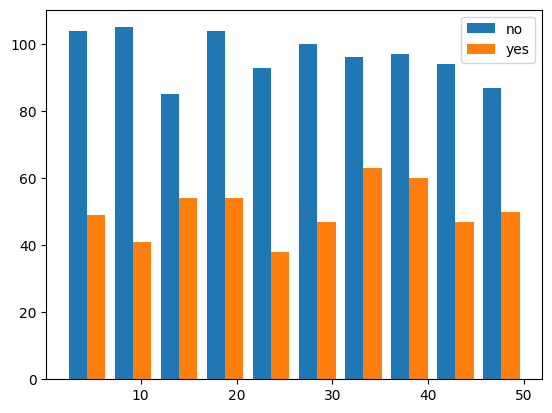

In [32]:
# Proporção de churn por Tenure
print("Churn por Tenure_Months")
ch_no = customers[customers.churn == 'no'].Tenure_Months
ch_yes = customers[customers.churn == 'yes'].Tenure_Months

plt.hist([ch_no, ch_yes], label=['no', 'yes'])
plt.legend()

# Preparação do dados para o modelo de classificação

Esta etapa representa o ponto inicial do processo de preparação dos dados direcionados ao modelo de classificação. O procedimento teve início com a remoção de colunas consideradas dispensáveis para a análise, incluindo informações como datas de vendas e identificadores de clientes. Isso foi seguido por um processo de codificação dos rótulos para campos que não apresentavam natureza numérica dentro do dataset, um passo fundamental para a utilização eficiente em modelos de classificação.

Além disso, duas estruturas de dados foram criadas: um dataframe para armazenar os atributos denominado "features" e outro para conter as classificações de cada registro, denominado "labels".

Por fim, os dataframes foram divididos em conjuntos de treino e teste, permitindo a separação apropriada dos dados para a construção e avaliação do modelo.

O objetivo principal desse estágio é simplificar e aprimorar o conjunto de dados, priorizando a relevância das informações essenciais para a construção eficaz do modelo.

In [38]:
# Preparar o dataset para ser utilizado no treinamento dos algoritmos de classificação

# Remover colunas não necessárias
customers_2 = customers.drop(['CustomerID', 'first_sale_date', 'last_sale_date'], axis=1)
print("Formato dos dados de entrada: ",customers_2.shape)

Formato dos dados de entrada:  (1468, 16)


In [39]:
# Codificar colunas não numéricas

customers_2['Gender'] = LabelEncoder().fit_transform(customers_2['Gender'])
customers_2['Location'] = LabelEncoder().fit_transform(customers_2['Location'])
customers_2.head()

,Gender,Location,Tenure_Months,days_between_sales,count_sales,used_coupon_count,unique_items_count,items_count,total_delivery_charges,total_spent,order_frequency,use_coupon_rate,avg_items_by_order,avg_delivery_charges_by_order,avg_spent_by_order,churn
0,1,1,12,25,177,91.0,119,1133,3162.62,34551.40,7.080000,0.514124,6.401130,17.867910,195.205650,yes
1,1,0,43,351,26,18.0,33,175,315.96,3048.79,0.074074,0.692308,6.730769,12.152308,117.261154,no
2,1,1,33,213,15,12.0,40,155,757.27,2361.48,0.070423,0.800000,10.333333,50.484667,157.432000,no
3,0,0,30,0,1,0.0,1,1,6.50,1.24,0.000000,0.000000,1.000000,6.500000,1.240000,yes
4,1,0,49,241,6,2.0,5,15,64.38,1043.72,0.024896,0.333333,2.500000,10.730000,173.953333,no


In [61]:
# UTILIZANDO TENSORFLOW

# separar features e labels

features = MinMaxScaler().fit_transform(customers_2.iloc[:,0:(customers_2.shape[1] - 1)])
le = LabelEncoder()
labels = le.fit_transform(customers_2.iloc[:,(customers_2.shape[1] - 1)])

[1 0 0 ... 0 0 0]


In [41]:
# Separa conjuntos de treino e teste

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42)
X_train.shape

(1247, 15)

# Criando o modelo de rede neural.

Inicialmente, um array foi criado para servir como inicialização do bias. Esse array foi construído considerando a proporção entre churn e não churn no conjunto de dados. Essa abordagem é crucial, já que o conjunto de dados apresenta um desequilíbrio leve. A inicialização não aleatória do bias ajuda o modelo a evitar dedicar tempo excessivo para aprender sobre o desbalanceamento e, assim, acelera o processo de aprendizado.

Foram conduzidos testes exploratórios com diferentes topologias de rede, learning_rate e otimizadores. Observou-se que ao utilizar um learning_rate mais baixo, o modelo enfrentou dificuldades na generalização, demandando um ajuste para um valor ainda mais baixo e treinamento por um maior número de épocas. Em uma das iterações, ao treinar o modelo por 2000 épocas, notou-se que por volta da época 1100, a acurácia no conjunto de teste começou a declinar em vez de aumentar, enquanto a loss permaneceu estagnada. Esses insights foram cruciais para a calibração dos hiperparâmetros e a compreensão do comportamento do modelo ao longo do treinamento.

Além disso, foi essencial aplicar a normalização em lote, uma vez que o modelo não estava aprendendo de maneira satisfatória. No entanto, essa técnica comprometeu a capacidade de generalização do modelo. Para lidar com esse overfitting, implementamos camadas de regularização por dropout e L2 (ridge), testando diferentes configurações até alcançar resultados mais favoráveis.

In [74]:
# Criando o modelo

def create_model():
  initial_bias = np.log([pos/neg])
  print(initial_bias)
  output_bias = tf.keras.initializers.Constant(initial_bias)


  model = Sequential([
      Dense(100, input_shape=(15,), activation='relu'),
      Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      BatchNormalization(),
      Dense(50, activation='relu'),
      Dropout(0.1),
      Dense(20, activation='relu'),
      Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  return model


In [44]:
import matplotlib.pyplot as plt

def plot(history):
  # Gráfico da evolução da perda durante o treinamento
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Perda (Loss) - Treino')
  plt.plot(history.history['val_loss'], label='Perda (Loss) - Teste')
  plt.xlabel('Épocas')
  plt.ylabel('Perda (Loss)')
  plt.title('Evolução da Perda durante o Treinamento')
  plt.legend()
  plt.show()

  # Gráfico da acurácia durante o treinamento
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['accuracy'], label='Acurácia - Treino')
  plt.plot(history.history['val_accuracy'], label='Acurácia - Teste')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.title('Evolução da Acurácia durante o Treinamento')
  plt.legend()
  plt.show()

In [ ]:
# Treinamento por 2000 épocas
model = create_model()
history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), verbose=1)

Epoch 1/2000
39/39 [==============================] - 4s 16ms/step - loss: 1.5523 - accuracy: 0.6544 - val_loss: 1.5373 - val_accuracy: 0.6380
Epoch 2/2000
39/39 [==============================] - 0s 8ms/step - loss: 1.5386 - accuracy: 0.6584 - val_loss: 1.5349 - val_accuracy: 0.6380
Epoch 3/2000
39/39 [==============================] - 0s 6ms/step - loss: 1.5213 - accuracy: 0.6608 - val_loss: 1.5324 - val_accuracy: 0.6380
Epoch 4/2000
39/39 [==============================] - 0s 8ms/step - loss: 1.5114 - accuracy: 0.6592 - val_loss: 1.5293 - val_accuracy: 0.6380
Epoch 5/2000
39/39 [==============================] - 0s 7ms/step - loss: 1.4995 - accuracy: 0.6592 - val_loss: 1.5259 - val_accuracy: 0.6380
Epoch 6/2000
39/39 [==============================] - 0s 6ms/step - loss: 1.4911 - accuracy: 0.6592 - val_loss: 1.5217 - val_accuracy: 0.6380
Epoch 7/2000
39/39 [==============================] - 0s 4ms/step - loss: 1.4763 - accuracy: 0.6624 - val_loss: 1.5170 - val_accuracy: 0.6380
Epoch

# Resultado do teste com 2000 épocas

Com base nos gráficos de perda e acurácia nos conjuntos de treinamento e teste, percebeu-se que a rede atingiu seu melhor desempenho por volta da época entre 1000 e 1100. Após esse ponto, o modelo começou a apresentar overfitting, refletindo na queda da acurácia no conjunto de teste.

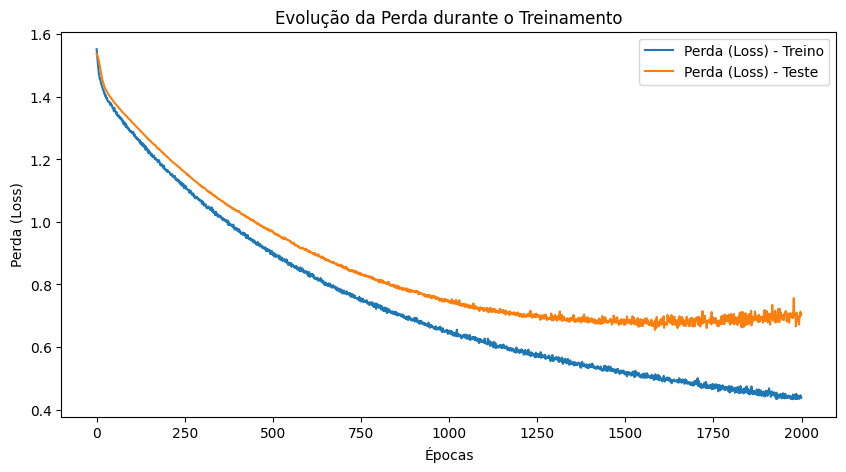

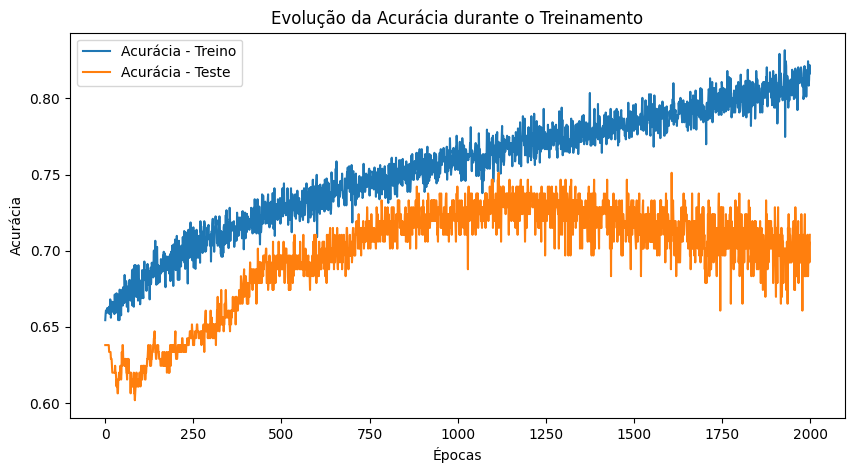

In [ ]:
plot(history)

In [78]:
# Rodando o modelo com 1000 épocas
model = create_model()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=1)

[-0.65153793]
Epoch 1/1000
39/39 [==============================] - 1s 9ms/step - loss: 1.5053 - accuracy: 0.6608 - val_loss: 1.5341 - val_accuracy: 0.6380
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4978 - accuracy: 0.6608 - val_loss: 1.5314 - val_accuracy: 0.6380
Epoch 3/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4981 - accuracy: 0.6608 - val_loss: 1.5284 - val_accuracy: 0.6380
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4929 - accuracy: 0.6608 - val_loss: 1.5251 - val_accuracy: 0.6380
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4829 - accuracy: 0.6608 - val_loss: 1.5214 - val_accuracy: 0.6380
Epoch 6/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4782 - accuracy: 0.6600 - val_loss: 1.5172 - val_accuracy: 0.6380
Epoch 7/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.4778 - accuracy: 0.6624 - val_loss: 1.5128 - val_accuracy:

# Resultado do teste com 1000 épocas

Analisando os gráficos, observou-se que o modelo demonstra uma acurácia de 69% no conjunto de teste.

No contexto da previsão de churn, minimizar os falsos negativos é crítico, já que é preferível prever incorretamente que um cliente pode deixar o serviço e ele não deixar a dizer que ele não sairá e ele acabar saindo.

No relatório de classificação, nota-se que o recall, uma medida que avalia a taxa de verdadeiros positivos, na classe 1 (representando churn), está em 51%.

Provavelmente, o baixo recall se deve ao desbalanceamento dos dados. Para contornar isso, estamos introduzindo o parâmetro class_weights para dar mais peso à classe 1 e incentivar o modelo a acertar mais nos verdadeiros positivos.


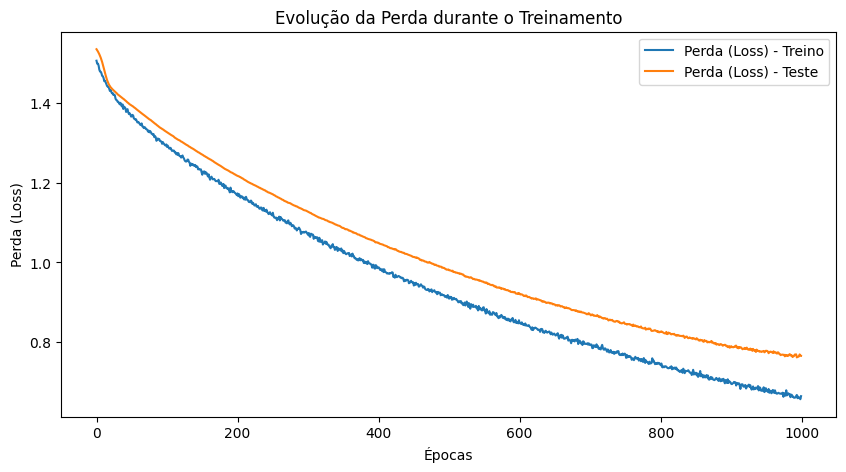

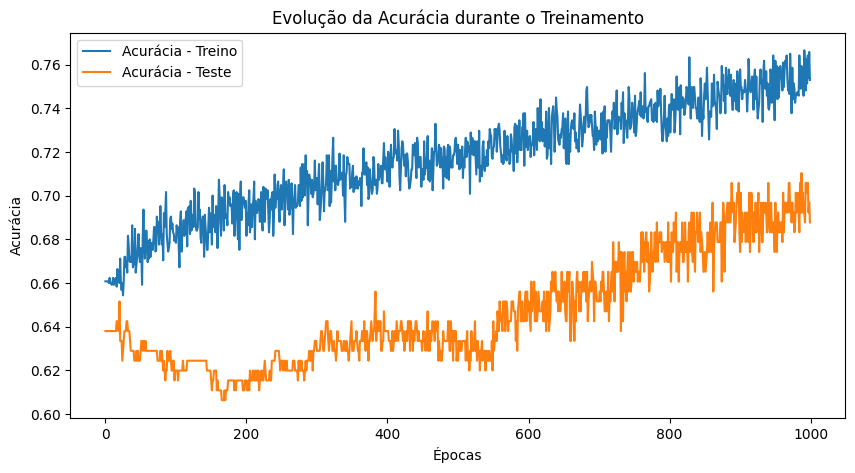

In [79]:
plot(history)

In [80]:
# Prever os rótulos para os dados de teste
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Transformar as probabilidades em rótulos binários

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Calculando outras métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 2ms/step
Matriz de Confusão:
[[111  30]
 [ 39  41]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       141
           1       0.58      0.51      0.54        80

    accuracy                           0.69       221
   macro avg       0.66      0.65      0.65       221
weighted avg       0.68      0.69      0.68       221



In [81]:
class_weights = {0: 1, 1: 1.3}
model = create_model()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), class_weight= class_weights, verbose=1)

[-0.65153793]
Epoch 1/1000
39/39 [==============================] - 1s 10ms/step - loss: 1.7063 - accuracy: 0.6014 - val_loss: 1.5399 - val_accuracy: 0.6380
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.6760 - accuracy: 0.6151 - val_loss: 1.5380 - val_accuracy: 0.6380
Epoch 3/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.6527 - accuracy: 0.6319 - val_loss: 1.5361 - val_accuracy: 0.6380
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.6434 - accuracy: 0.6271 - val_loss: 1.5343 - val_accuracy: 0.6380
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.6271 - accuracy: 0.6359 - val_loss: 1.5322 - val_accuracy: 0.6380
Epoch 6/1000
39/39 [==============================] - 0s 5ms/step - loss: 1.6136 - accuracy: 0.6536 - val_loss: 1.5298 - val_accuracy: 0.6380
Epoch 7/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.6046 - accuracy: 0.6496 - val_loss: 1.5267 - val_accuracy

# Resultado introduzindo class_weights

Utilizando um peso 1.3 para a classe 1 foi mantida a acurácia de 69% no conjunto de teste e observado um aumento no recall da classe 1 para 68%.

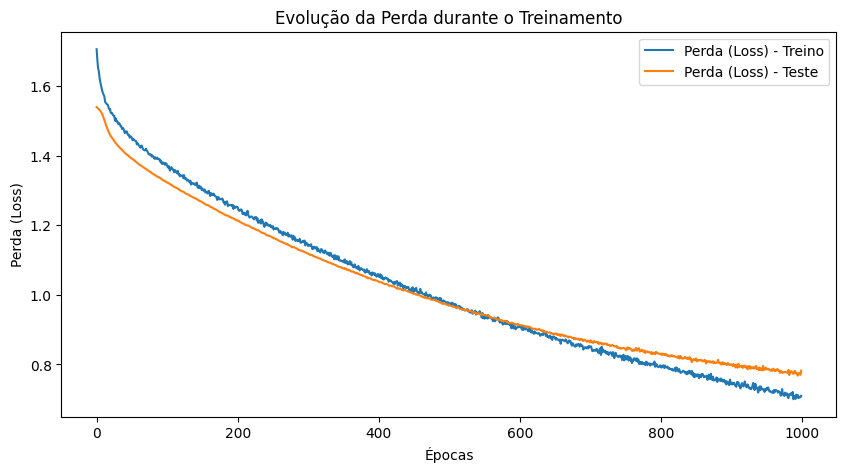

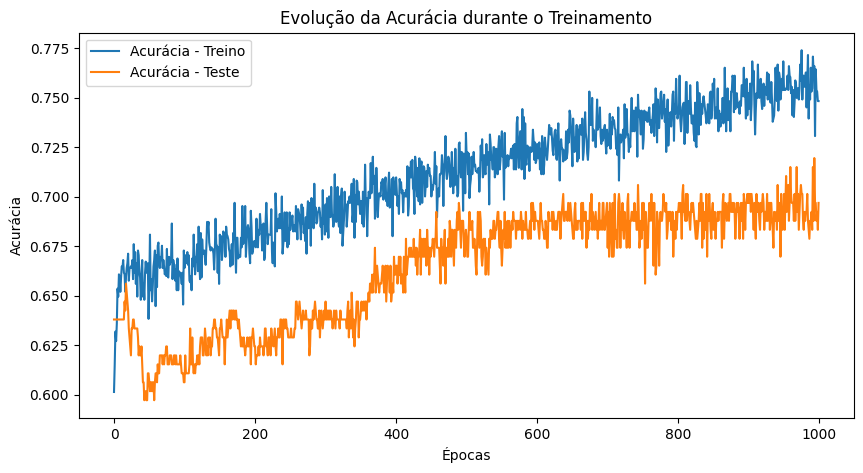

In [82]:
plot(history)

In [83]:
# Prever os rótulos para os dados de teste
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Transformar as probabilidades em rótulos binários

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Calculando outras métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 3ms/step
Matriz de Confusão:
[[100  41]
 [ 26  54]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       141
           1       0.57      0.68      0.62        80

    accuracy                           0.70       221
   macro avg       0.68      0.69      0.68       221
weighted avg       0.71      0.70      0.70       221



In [75]:
class_weights = {0: 1, 1: 2}
model = create_model()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), class_weight= class_weights, verbose=1)

[-0.65153793]
Epoch 1/1000
39/39 [==============================] - 1s 9ms/step - loss: 1.9035 - accuracy: 0.6608 - val_loss: 1.5406 - val_accuracy: 0.6380
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.8582 - accuracy: 0.6560 - val_loss: 1.5370 - val_accuracy: 0.6380
Epoch 3/1000
39/39 [==============================] - 0s 5ms/step - loss: 1.8201 - accuracy: 0.6488 - val_loss: 1.5329 - val_accuracy: 0.6380
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.7863 - accuracy: 0.6560 - val_loss: 1.5287 - val_accuracy: 0.6380
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.7558 - accuracy: 0.6431 - val_loss: 1.5239 - val_accuracy: 0.6380
Epoch 6/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.7476 - accuracy: 0.6415 - val_loss: 1.5188 - val_accuracy: 0.6380
Epoch 7/1000
39/39 [==============================] - 0s 4ms/step - loss: 1.7354 - accuracy: 0.6391 - val_loss: 1.5133 - val_accuracy:

# Resultado com class_weights aumentado

Foi feito um novo treinamento, desta vez com o peso da classe 1 (churn) como 2.0.
O resultado ostrou uma leve queda da acurácia para 66%, porém o recall da classe 1 subiu para 78%, indicando que o modelo aprimorou a capacidade de detecctar os verdadeiros positivos.

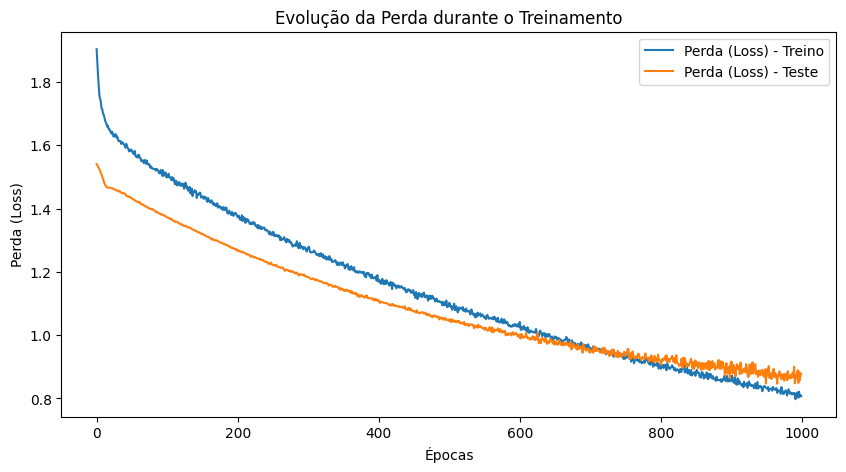

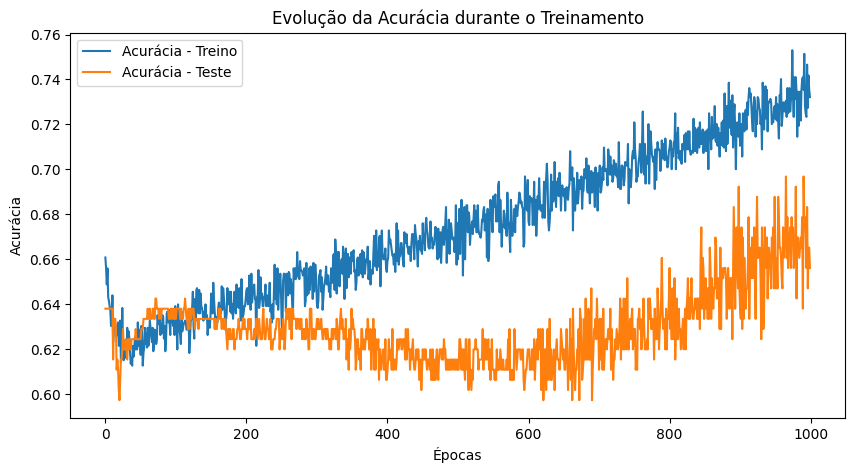

In [76]:
plot(history)

In [77]:
# Prever os rótulos para os dados de teste
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Transformar as probabilidades em rótulos binários

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Calculando outras métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 3ms/step
Matriz de Confusão:
[[83 58]
 [18 62]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       141
           1       0.52      0.78      0.62        80

    accuracy                           0.66       221
   macro avg       0.67      0.68      0.65       221
weighted avg       0.71      0.66      0.66       221



# Conclusão

O projeto de previsão de churn apresentou avanços significativos no desempenho do modelo a partir de ajustes nos pesos das classes. Inicialmente, a acurácia se manteve em 69%, e o recall para a classe de churn (classe 1) estava em 51%. A implementação de diferentes pesos para essa classe trouxe melhorias substanciais. Com um peso de 1.3, a acurácia permaneceu estável, mas o recall da classe 1 subiu para 68%, sinalizando uma melhoria na detecção de verdadeiros positivos. No entanto, ao elevar o peso da classe 1 para 2.0, houve uma leve queda na acurácia para 66%, mas um substancial aumento no recall da classe 1, alcançando 78%. Isso evidencia que ajustes nos pesos das classes podem otimizar a capacidade do modelo de detectar clientes propensos ao churn, resultando em uma melhor performance na identificação dos verdadeiros positivos.